# Evaluate LLM application against fixed dataset


At a high level, in this tutorial we will go over how to:

- Create an initial golden dataset to measure performance
- Define metrics to use to measure performance
- Run evaluations on a few different prompts or models
- Compare results manually
- Track results over time
- Set up automated testing to run in CI/CD

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="langsmith-evaluations"

# Create a dataset


In [ ]:
from langsmith import Client

client = Client()

# Define dataset: these are your test cases
dataset_name = "QA Example Dataset"
dataset = client.create_dataset(dataset_name)
client.create_examples(
    inputs=[
        {"question": "What is LangChain?"},
        {"question": "What is LangSmith?"},
        {"question": "What is OpenAI?"},
        {"question": "What is Google?"},
        {"question": "What is Mistral?"},
    ],
    outputs=[
        {"answer": "A framework for building LLM applications"},
        {"answer": "A platform for observing and evaluating LLM applications"},
        {"answer": "A company that creates Large Language Models"},
        {"answer": "A technology company known for search"},
        {"answer": "A company that creates Large Language Models"},
    ],
    dataset_id=dataset.id,
)

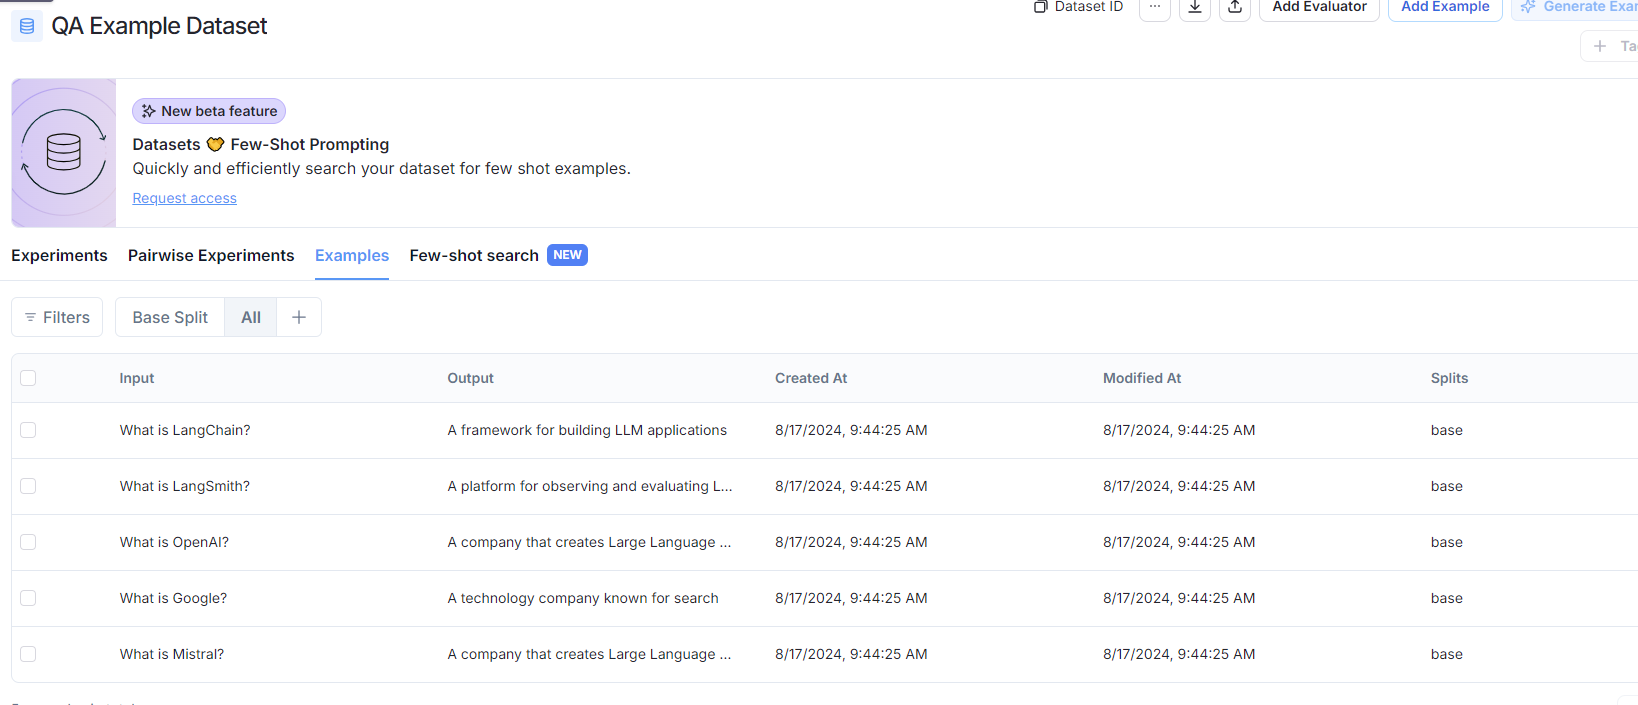

# Define metrics

### Metrics-1:

we will use an LLM to judge whether the output is correct (with respect to the expected output). This LLM-as-a-judge is relatively common for cases that are too complex to measure with a simple function. 

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts.prompt import PromptTemplate
from langsmith.evaluation import LangChainStringEvaluator

_PROMPT_TEMPLATE = """You are an expert professor specialized in grading students' answers to questions.
You are grading the following question:
{query}
Here is the real answer:
{answer}
You are grading the following predicted answer:
{result}
Respond with CORRECT or INCORRECT:
Grade:
"""

PROMPT = PromptTemplate(
    input_variables=["query", "answer", "result"], template=_PROMPT_TEMPLATE
)
eval_llm = ChatOpenAI(model="gpt-4o-mini",temperature=0.0)

qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm, "prompt": PROMPT})

### Metrics-2:

For evaluating the length of the response - We can just define a simple function that checks whether the actual output is less than 2x the length of the expected result.

In [ ]:
def evaluate_length(run, example):
    # Access the content of the AIMessage
    prediction = run.outputs["output"].content
    required = example.outputs.get("answer") or ""
    
    # Now calculate the length of the content
    score = int(len(prediction) < 2 * len(required))
    return {"score": score}


# Sample Application
Now that we have a dataset and evaluators, all that we need is our application! 

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def my_app(question):
    return llm(
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "Respond to the users question in a short, concise manner (one short sentence)."
            },
            {
                "role": "user",
                "content": question,
            }
        ],
    )

In [ ]:
def langsmith_app(inputs):
    output = my_app(inputs["question"])
    return {"output": output}

In [ ]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app, # Your AI system
    data=dataset_name, # The data to predict and grade over
    evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
    experiment_prefix="openai-evaluation", # A prefix for your experiment names to easily identify them
)